# Folium Mapping
    
Because github cannot render folium maps I'll have to provide a link to nbviewer so show the actual maps. 

https://nbviewer.jupyter.org/github/christophmckinzie/influenza_ny/blob/main/FoliumMapping.ipynb#

I have to give a shout out to this Towards Data Science article for helping me understand folium maps.__[Making 3 Easy Maps with Python](https://towardsdatascience.com/making-3-easy-maps-with-python-fb7dfb1036)__

In [1]:
# Required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import folium
import re
import branca
import os
import json
import requests

In [2]:
# Load file
filename = 'https://raw.githubusercontent.com/christophmckinzie/influenza_ny/main/influenza_ny.csv'
df = pd.read_csv(filename)
df.head()

,season,region,county,cdc_week,week_ending_date,disease,count,county_centroid,fips
0,2009-2010,NYC,BRONX,3,2010-01-23,INFLUENZA_B,1,POINT(-73.8648 40.8448),36005
1,2009-2010,NYC,BRONX,17,2010-05-01,INFLUENZA_A,7,POINT(-73.8648 40.8448),36005
2,2009-2010,NYC,BRONX,17,2010-05-01,INFLUENZA_B,0,POINT(-73.8648 40.8448),36005
3,2009-2010,NYC,BRONX,50,2009-12-19,INFLUENZA_A,62,POINT(-73.8648 40.8448),36005
4,2009-2010,NYC,BRONX,50,2009-12-19,INFLUENZA_B,2,POINT(-73.8648 40.8448),36005


### Exploring Infection Trends

Looking at the dynamics of each type of influenza we can see that in general type A is more common than B. Also interesting is that influenza type B infections peaks sometime after type A has made its peak.

Text(0.5, 1.0, 'Infection Counts by Week')

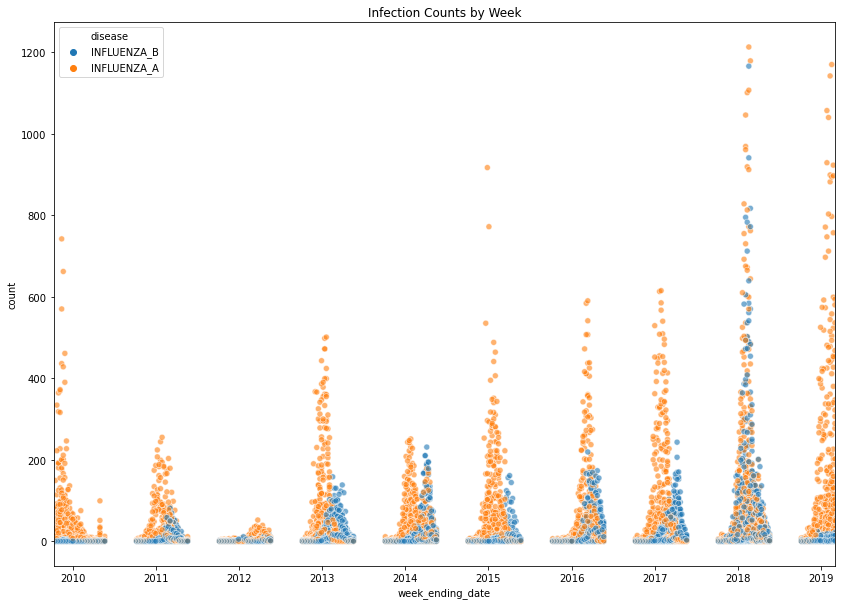

In [3]:
fig = plt.figure(figsize = (14, 10))
sns.scatterplot(data=df[df['disease'] != 'INFLUENZA_UNSPECIFIED'], x = pd.to_datetime(df['week_ending_date']), y = 'count', hue='disease', alpha=.6)
plt.xlim(pd.to_datetime(df['week_ending_date']).min(), pd.to_datetime(df['week_ending_date']).max())
plt.title('Infection Counts by Week')

Here we see the counts of each influenza type for each region of New York. We can see that for some of these regions different types are more seroprevalent. 

C:\Users\Chris\anaconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


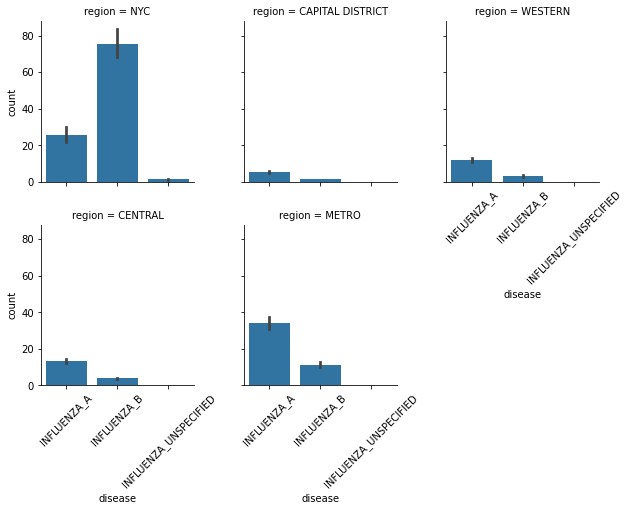

In [4]:
g = sns.FacetGrid(df, col="region", col_wrap = 3)
g = g.map(sns.barplot, 'disease', 'count')
g.set_xticklabels(rotation = 45)

# Folium Mapping

The feature values for county_centroid are in an unfortunate format (e.g. 'POINT(-73.8648 40.8448)'). We can use regular a expression to extract our relevant data. I prefer to have the lat and lon as seperate columns here. 

In [5]:
# regular expression to extract digits
gps = lambda x: re.findall(r'-?\d+\.?\d*', x)
df['county_centroid'] = df['county_centroid'].apply(gps)

# itterate through column and append to list
lat = []
for i in np.arange(0, len(df), 1):
    lat.append(df['county_centroid'][i][1])

lon = []
for i in np.arange(0, len(df), 1):
    lon.append(df['county_centroid'][i][0])
    
# create new lat and lon columns
df['lat'] = lat
df['lon'] = lon

We need to make a function to extract unique lists of coordinates as well as perserve the values order so we can match their corresponding count averages. 

When creating our folium map we cannot plot all 56,000 points and because we have a reoccuring longitude value I'll choose to create a new dataframe to more easily plot our data.

The function below iterates through each value and returns the value and adds it to the list if it isn't already in the noDupes list. 

In [6]:
# function to extract unique lists of coordinates 
def unique_lists(seq): 
   # order preserving
   noDupes = []
   [noDupes.append(i) for i in seq if not noDupes.count(i)]
   return noDupes

# apply unique_list function 
folium_df = pd.DataFrame(unique_lists(list(df['county_centroid'])), columns=['lon', 'lat'])

Now we add the average count for each county.

Important to this dataset is a shared longitude value for two counties. If we were to group by longitude we would miss one county.

In [7]:
# Now we add the average count for each county. 
folium_df['avg_county_count'] = df.groupby('lat', sort=False).mean()['count'].values
folium_df['county_name'] = df.groupby('lat', sort=False).first()['county'].values

# We need to have a key value so the geojson file and our data frame can match the correct shading values for count.
folium_df['FIPS_Code'] = df.groupby('lat', sort=False).first()['fips'].values

Below is my first go at making the map. There is too much going on with the county lines and circles and just looks poor. There are too many locations in New York city and the circles 

In [8]:
# Here is the county boundaries for new york state
url = 'https://raw.githubusercontent.com/christophmckinzie/influenza_ny/main/ny_counties_geojson.json'

# Set up the folium map here centered at New York state
folium_map = folium.Map(location=[42.5, -74], zoom_start=6)

# Here we add the county boundaries to the folium map
folium.GeoJson(url, name='geojson').add_to(folium_map)

# Adding each point to the map with cooresponding radius
for index, row in folium_df.iterrows():
    
    # generate the popup message that is shown on click.
    popup_text = "{}<br> county_name: {}"
    popup_text = popup_text.format(index, row["county_name"], row["avg_county_count"])
    
    folium.CircleMarker(location=(row["lat"],
                                  row["lon"]),
                        radius= row['avg_county_count']/2,
                        color="#E37222",
                        popup=popup_text,
                        fill=False).add_to(folium_map)
    
folium_map

The map below is much better. The next thing I would like to try to do is add clickable popups which will be based off the solution here https://github.com/python-visualization/folium/issues/904 but is a little more complicated is taking me a while to figure out. 

In [9]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
county_geo = f'{url}/us_counties_20m_topo.json'

colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 50e3)
count_series = folium_df.set_index('FIPS_Code')['avg_county_count']*1000

def style_function(feature):
    count = count_series.get(int(feature['id'][-5:]), None)
    return {
        'fillOpacity': 0 if count is None else 0.8,
        'weight': 0 if count is None else 0.3,
        'fillColor': 'white' if count is None else colorscale(count)
    }

m = folium.Map(
    location=[42.8, -75.2],
    tiles='cartodbpositron',
    zoom_start=6.5
)

folium.TopoJson(
    json.loads(requests.get(county_geo).text),
    'objects.us_counties_20m',
    style_function = style_function
).add_to(m)

m